[View in Colaboratory](https://colab.research.google.com/github/aunz/ds/blob/master/Collaborative_filtering.ipynb)

# Collaborative Filtering
Implementation of collaborative filtering with the memory based approach


This approach is quite simple. It find users who share some degrees of similarity and take weighted average of weightings. Similarity can be defined as cosine similarity or pearson correlation (more on this later).

We are going to use the MovieLens dataset, a classic dataset for training recommendation models. It consists of 100,000 movies ratings from ~ 1000 uers, on a scale of 1 to 5.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Fetch and format the data. It has:
- 943 users
- 1682 movies
- The sparsity is 6.3%, which means 6.3% of the dataset has some ratings

In [13]:
%%time
!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

data = pd.read_csv('./ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
print(data.head())

# re-format the dataset to user_id x item_id (row x column)
data = data.pivot(index='user_id', columns='item_id', values='rating') # this is a user-by-item matrix
data.fillna(0, inplace=True) # fill NaN with 0

# some simple stats
print('User: {}, item: {}'.format(*data.shape))
print(f'Sparsity: {((data > 0).sum().sum() / (data.shape[0] * data.shape[1]) * 100):.2f}%') # number of non-zero devided by total number of cells

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  2177k      0  0:00:02  0:00:02 --:--:-- 2176k
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test       

# New Section

- Ratings are 1, 2, 3, 4, 5. The majority is 4. Zero means no rating.
- Each user rated at least 20 items, the median is 65
- Each item received at least 1 rating, the median is 27


In [178]:
print(pd.Series(data.values.ravel()).value_counts())

pd.concat([
    data.apply(lambda x: (x != 0).sum(), 1).describe(), # user, by row
    data.apply(lambda x: (x != 0).sum(), 0).describe() # item, by col
], 1, keys=['user', 'item'])

0.0    1486126
4.0      34174
3.0      27145
5.0      21201
2.0      11370
1.0       6110
dtype: int64


,user,item
count,943.000000,1682.000000
mean,106.044539,59.453032
std,100.931743,80.383846
min,20.000000,1.000000
25%,33.000000,6.000000
50%,65.000000,27.000000
75%,148.000000,80.000000
max,737.000000,583.000000


We will split the data into train and test set, by removing 10 ratings per user from the train set and putting them into the test set

In [179]:
train = np.zeros_like(data)
test = np.zeros_like(data)

np.random.seed(0)
for i, row in enumerate(np.array(data)):
    test_index = np.random.choice(row.nonzero()[0], size=10, replace=False) # take out 10 random non-zero item without replacement from the row
    train[i] = row.copy()
    train[i, test_index] = 0 # in the train set, these will be turned into 0
    test[i, test_index] = row[test_index]

assert(np.all((train * test) == 0)) # train & test set are fully disjoint

print('train set sparsity (%):', np.count_nonzero(train) / (train.shape[0] * train.shape[1]) * 100)
print('test set sparsity (%):', np.count_nonzero(test) / (test.shape[0] * test.shape[1]) * 100)

train set sparsity (%): 5.710139043178159
test set sparsity (%): 0.5945303210463734


### Collaborative filtering

There are 2 types:
- User based
- Item based

For either type, we will build a similarity matrix consisting of distances that mearuse the similairty between tow data points.
- For user based, this is the distance between any two pairs of users
- For tiem based, this is the distance between any two pairs of items.

### How do we measure similarity?
One of the most popular is [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

We can imagine each user is a vector in a N-dimensional space of N-items. If two users have rated the same items, their vectors will point to the same direction and their cosine-similarity is 1. If they rated different items, their vectors will point to different directions. If the direction is completely opposite, the cosine-similarity is -1. If the direction is orthogonal (they rated items exclusive to one another), the cosine-similarity is 0.


The other option is [pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

In [180]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

# calculate similarity
sim_user = 1 - pairwise_distances(train, metric='cosine') # user based, 1 - distance = similarity
sim_item =  1 - pairwise_distances(train.T, metric='cosine') # item based, just transpose

print('user based', sim_user.shape, '\n', sim_user[:5, :5])
print('\nitem based', sim_item.shape, '\n', sim_item[:5, :5])

user based (943, 943) 
 [[1.         0.14971307 0.03905355 0.05301196 0.36493224]
 [0.14971307 1.         0.11611837 0.15900017 0.07995677]
 [0.03905355 0.11611837 1.         0.21029038 0.02425788]
 [0.05301196 0.15900017 0.21029038 1.         0.02781854]
 [0.36493224 0.07995677 0.02425788 0.02781854 1.        ]]

item based (1682, 1682) 
 [[1.         0.4221154  0.31424115 0.44777373 0.30245373]
 [0.4221154  1.         0.2636396  0.45970359 0.32723722]
 [0.31424115 0.2636396  1.         0.34738525 0.22612435]
 [0.44777373 0.45970359 0.34738525 1.         0.35602466]
 [0.30245373 0.32723722 0.22612435 0.35602466 1.        ]]


For user-based collaborative filtering, we predict user $u$'s rating for item $i$ is the weighted sum of all other users’ ratings for item $i$ where the weighting is the cosine similarity between the each user and the user $u$ of interest.

This is clearer in the table below.

We have 6 users and want to predict user 0's rating for item 1.
- In row A, we have the similarity metric to user 0. User 1 is 0.9 similar to user 0, user 2 is only 0.1 to user 0, and so on
- In row B, we have ratings for item 1 from different users. User 1 gave a rating of 4, user 2 gave a rating of 5, etc.
- In row C, we multiple the similaritys with ratings 
- In the sum column, we simly add all the similarity × rating together
- Then to predict user 0's rating for item 1, we devide the sum of similarity × rating by the sum of similairty (this acts as a normalizer)


| |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Row || <td colspan=6 align="centre">User</td> || Sum
| | || 0 | 1 | 2 | 3 | 4 | 5 | | 
| A | similarity to user 0 || 1 | 0.9 | 0.1 | 0.7 | 0.3 | 0.5 | | **3.5**
| B | rating item 1 || **?** | 4 | 5 | 2 | 0 | 1 |
| C | similarity × rating || 0 | 3.6 | 0.5 | 1.4 | 0.0 | 0.5 || **6.0**
Table 1

Predicted rating of  **user 0** for *item 1* is: 6.0 / 3.5 = **1.7**

Now we implement this in Numpy

In [0]:
def predict(ratings, similarity):
    # example: predict(data.iloc[:, [10]], sim_user[[2]]) to predict user2's rating for item10
    # predict(data.T.iloc[:, [20]], sim_item[[6]]) to predict item6's rating from user20
    tmp = similarity.dot(ratings) # dot product to get the rating, this is the similarity × rating
    tmp /= np.abs(similarity).sum(1).reshape(-1, 1) # normalised by number of ratings
    tmp = np.round(tmp, 0) # round to nearest 0
    return tmp

# predict(train[:,:10], sim_user[[0, 1, 2]])

Now we can defien a metric to measure how good our predictions are. In this case we use mse

We can see that user based are a little bit better than item based

In [8]:
from sklearn.metrics import mean_squared_error as score

# def score(y_true, y_pred):
#     tmp = np.sum((y_true != 0) | (y_pred != 0)) # number of non-zero items
#     tmp = np.sum((y_true == y_pred) & (y_true != 0) & (y_pred != 0)) / tmp # number of correct labels without counting zero
#     return tmp

# user based
tmp = predict(train, sim_user)
print(f'''User based
Train set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(train, tmp):.4f}''')

print(f'''
Test set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(test, tmp):.4f}''')


# # item based
tmp = predict(train.T, sim_item)
print(f'''
Item based
Train set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(train.T, tmp):.4f}''')

print(f'''
Test set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(test.T, tmp):.4f}''')

User based
Train set
Min rating: 0.0
Max rating: 4.0
Score: 0.6225

Test set
Min rating: 0.0
Max rating: 4.0
Score: 0.2717

Item based
Train set
Min rating: 0.0
Max rating: 4.0
Score: 0.6894

Test set
Min rating: 0.0
Max rating: 4.0
Score: 0.3049


If we look at the similarities between users (graph below), we notice that most of them are not very similar. It is likely that the sheer amount of zeros and dis-similarities overwhelme the prediction.

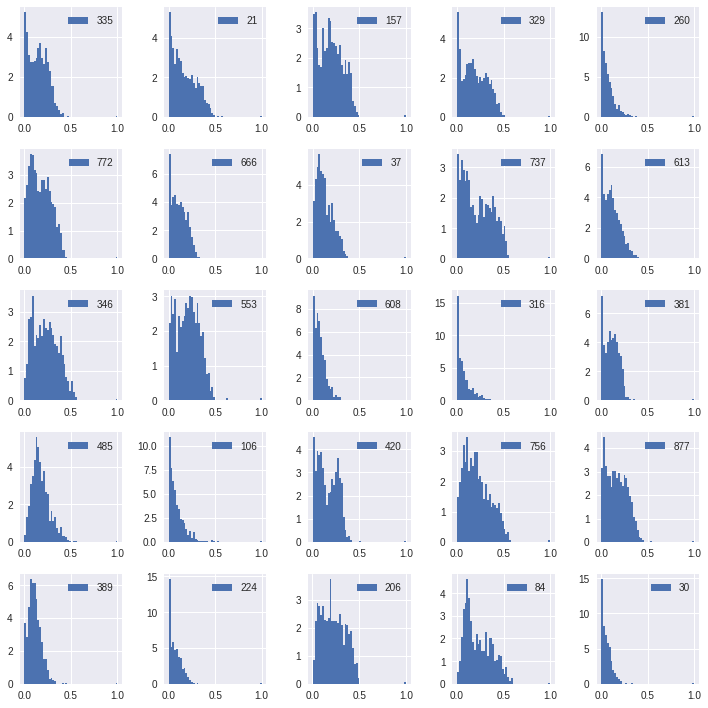

In [9]:
# pd.DataFrame(sim_user).head(10)
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, user in enumerate(np.random.choice(range(len(sim_user)), 25, replace=False)):
    plt.subplot(5, 5, i + 1)
    plt.hist(sim_user[user], 50, label=str(user), normed=True)
    plt.legend()

plt.tight_layout()

So for user-based collaborative filtering, instead of using all the weights from all the other users, we use the weights from top $k$ users with the highest similarity to the user of interest.

Recall in our table 1 above, we see that user 1 has the highest similarity (0.9) to user 0 and user 1 gave a rating of 4 for item 1. However, the predicted rating for user 0 is 1.7. If we only keep the users with high similairties to user 0, we have something in table 2. Our predicted rating has nudged from 1.7 to 1.8

| |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Row || <td colspan=4 align="centre">User</td> || Sum
| | || 0 | 1 | 3 | 5 | | 
| A | similarity to user 0 || 1 | 0.9 |  0.7 |  0.5 | | **3.1**
| B | rating item 1 || **?** | 4 | 2 | 1 |
| C | similarity × rating || 0 | 3.6 | 1.4 | 0.5 || **5.5**
Table 2

Predicted rating of  **user 0** for *item 1* is: 5.5 / 3.1 = **1.8** using only the top 3 users

So you can imagine, depending on how many users, the final rating may change quite drastically.

Now, we adjust our predict function, adding a param *k* to specify how many top users we want to include

In [0]:
# redefine the function to take in a param k (the number of user)
def predict(ratings, similarity, k = None):
    if k is None: k = similarity.shape[1]
#     if k > len(similarity): raise ValueError('K need to be smaller than', len(similarity))
    preds = np.zeros((len(similarity), ratings.shape[1])) # our predictions
    indexes = np.argsort(similarity)[:,::-1][:,:k] # get indexes of similarity from large to small, only take the top k
    for i, index in enumerate(indexes):
        s = similarity[i, index]
        r = ratings[index,:]
        tmp = s.dot(r)
        tmp /= np.abs(s).sum()
#         tmp /= s.dot(r > 0) # some may be zero
#         tmp = np.where(np.isnan(tmp), 0, tmp)
        tmp = np.round(tmp, 0)
        preds[i] = tmp
    return preds

# predict(train[:,:5], sim_user[[0, 1, 2]], 5)
# predict(train[:,1680:], sim_user[[0, 1, 2]], 5)
# predict(train.T[:,:10], sim_item[[0, 1, 2]], 25)

User based
Train set
Min rating: 0.0
Max rating: 5.0
Score: 0.4520

Test set
Min rating: 0.0
Max rating: 5.0
Score: 0.5821

Item based
Train set
Min rating: 0.0
Max rating: 5.0
Score: 0.4454

Test set
Min rating: 0.0
Max rating: 5.0
Score: 0.6331


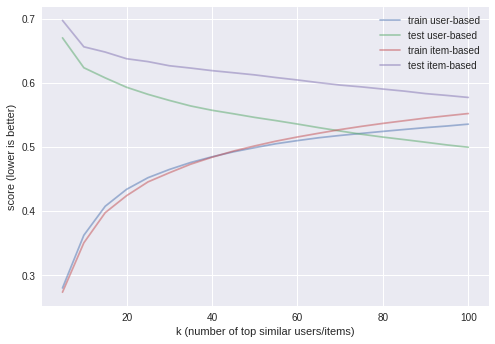

In [58]:
from sklearn.metrics import mean_squared_error as score

k = 25

# user based
tmp = predict(train, sim_user, k)
print(f'''User based
Train set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(train, tmp):.4f}''')

# tmp = predict(test, sim_user, k)
print(f'''
Test set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(test, tmp):.4f}''')


# # item based
tmp = predict(train.T, sim_item, k)
print(f'''
Item based
Train set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(train.T, tmp):.4f}''')

# tmp = predict(test.T, sim_item, k)
print(f'''
Test set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(test.T, tmp):.4f}''')

ranges = range(5, 101, 5)
tmp = [predict(train, sim_user, i) for i in ranges]
plt.plot(ranges, [score(train, i) for i in tmp], '-', label='train user-based', alpha=0.5)
plt.plot(ranges, [score(test, i) for i in tmp], '-', label='test user-based', alpha=0.5)
                         
tmp = [predict(train.T, sim_item, i) for i in ranges]
plt.plot(ranges, [score(train.T, i) for i in tmp], '-', label='train item-based', alpha=0.5)
plt.plot(ranges, [score(test.T, i) for i in tmp], '-', label='test item-based', alpha=0.5)

plt.xlabel('k (number of top similar users/items)')
plt.ylabel('score (lower is better)')
plt.legend();

### Recommendation

So now we know how to implement collaborative filtering (albeit a bit basic), how do we know if it can make good recommendations?

In the downloaded files, there is a "u.item" where we can get the title of the movies

In [0]:
movies = {}
with open('./ml-100k/u.item', 'r', encoding="ISO-8859-1") as f:
    for line in f.readlines():
        info = line.split('|')
        num = info[0]
        title = info[1].split('(')[0].strip()
        year = info[2][-4:]
        movies[num] = { 'title': title, 'year': year }
        
list(movies.items())[:5]

We are going to use a movide database API, such as www.omdbapi.com, to retrieve more information, such as posters.

We will need an API key and a requests module. I am saving all the movies into a pickle file so we don't need to hit the API server again in the future. We can then load this pickle file in the future.

In [0]:
# # First, we need an API key
# apiKey = input("Enter API Key:\t")

In [0]:
# %%time

# import requests

# # response = requests.get('http://www.omdbapi.com/?apikey=BanMePlz&t=D3: The Mighty Ducks&y=1996')
# for movie in movies.values():
#     if 'content' in movie and 'Poster' in movie['content']: continue
#     url = f'http://www.omdbapi.com/?apiKey={apiKey}&t={movie["title"]}&y={movie["year"]}'
#     response = requests.get(url)
#     if response.ok is False:
#         print('Can not get', movie['title'], movie['year'], response.text)
#         continue
#     movie['content'] = response.json()
#     print('Done:', movie['title'])

In [0]:
# import pickle

# with open('movies.pickle', 'wb') as handle:
#     pickle.dump(movies, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('movies.pickle', 'rb') as handle:
#     movies = pickle.load(handle)

Let's look at some of the movies!

In [274]:
from IPython.display import display, HTML

# given ids, show the poster
def show_posters(ids):
    tmp = []
    for i in ids:
        i = str(i + 1)
        m = movies[i]
        s = f'<span style="display:inline-block; box-sizing: border-box; width:128px; height:192px; margin:6px; border:1px solid #888; text-align: center; vertical-align: bottom">{m["title"]} ({m["year"]})</span>'
        if 'content' not in m:
            tmp.append(s)
            continue
        if 'Poster' not in m['content']:
            tmp.append(s)
            continue
        tmp.append(f'<img style="margin:6px; height:192px" src="{m["content"]["Poster"]}" height=192 alt="{i}">')
    display(HTML(''.join(tmp)))
    return tmp
   
# show the first 5 movies in the dataset
show_posters(range(5));

#### Toy Story
Is first movie in the dataset! Sweet!
- We are going to find the most similar movies to Toy Story
- We then display these movies

We get: Independence Day, Star Wars, Return of the Jedi and Star Trek! 😅

Mmm, I wouldn't pick Indepence Day, it's not my 🍵, maybe yours?

In [242]:
# get the 5 most similar movies to Toy Story according to the similarity matrix we computed earlier
tmp = np.argsort(sim_item[0])[:-6:-1]

# then display them
show_posters(tmp);

#### Golden Eye 007
Second movie in the dataset. Its most similar movies are: Under siege, True Lies, Batman, Top Gun.



In [272]:
tmp = np.argsort(sim_item[1])[:-6:-1]
show_posters(tmp);

#### Batman

Most similar to Batman are: Die Hard, Batman Returns.

Well, at least we have Batman Returns 🦇 nanananana?

In [280]:
print('Most similar to Batman')
show_posters(np.argsort(sim_item[402])[:-6:-1]);

Most similar to Batman


As we mentioned at the beginning, there are several ways to calculate similarity. 

We have already used cosine similarity. Now, we can try **Pearson correlation** to compute similarities. 

In [0]:
# use correlation instead of cosine similarity
cor_item = 1 - pairwise_distances(train.T, metric='correlation')
cor_item[np.isnan(cor_item)] = 0 # nan results stem from when 2 variables have the exact number, such as v1: [0, 0, 0, 0], v2 is also: [0, 0, 0, 0]

Now look at these movies again.

In [279]:
print('Most similar to Toy Story')
show_posters(np.argsort(cor_item[0])[:-6:-1]); # toy story

print('Most similar to Golden Eye 007')
show_posters(np.argsort(cor_item[1])[:-6:-1]); # 007

print('Most similar to Independence Day')
show_posters(np.argsort(cor_item[120])[:-6:-1]);

print('Most similar to Aladdin')
show_posters(np.argsort(cor_item[94])[:-6:-1]);

print('Most similar to Batmannnnnnnnaaa')
show_posters(np.argsort(cor_item[402])[:-6:-1]);


Most similar to Toy Story


Most similar to Golden Eye 007


Most similar to Independence Day


Most similar to Aladdin


Most similar to Batmannnnnnnnaaa


They are more or less the same 😐, similar movies are returned using correlation compared to cosine similarity.

Nonetheless, I hope you understand the basics in collaborative filtering and recommendation systems using the memory-based approach. It is intuitive. However its simplicity means there are a few cons:
- Data sparsity and cold start problem. There are so many unrated items and new users need to rate enough items for the system to make a meaningful recommendation. Similarly new items will also face the same problem of not having many ratings.
- Scalability. The system can not scale well when there are millions of users × items.
- Gray sheep & black sheep 🐑 🐏 



We will explore more advanced approaches in the next notebooks.

- Memory based technique ✓ this notebook
- Model-based using machine learning algorithms, next notebook
- Hybrid, next notebooke



<br />
<br />
References:
- https://en.wikipedia.org/wiki/Collaborative_filtering
- https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/